## <u>Notebook Synopsis</u>:<br>

Here I develop a set of models similar to that of Step-1-, here substituting the single trend component for a piecewise trend sub-model. Specifically I:

* Load the training data generated and saved in previous NB.
* Develop and combine piecewise trend, seasonal, and residual noise submodels similar to  previous NB.
* Compare models using WAIC or PSIS-LOOCV.
* Retain and save models predicted to perform better.

In [2]:
import pickle
import pathlib
from platform import python_version as pyver

import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from sklearn.preprocessing import MinMaxScaler

import arviz as ar
import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams

In [3]:
def print_ver(pkg, name=None):
    try:
        print(f'{pkg.__name__}: {pkg.__version__}')
    except AttributeError:
        print(f'{name}: {pkg}')

In [4]:
print_ver(pyver(), 'python')
for pi in [np, pd, pm, ar]:
    print_ver(pi)

python: 3.7.3
numpy: 1.16.4
pandas: 0.24.2
pymc3: 3.7
arviz: 0.4.1


In [5]:
%matplotlib inline

years = mdates.YearLocator(day=1)
months = mdates.MonthLocator(bymonthday=1)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-3, 2)

In [9]:
with open('../../pickleJar/datadict.pkl', 'rb') as fb:
    datadict = pickle.load(fb)

In [10]:
d_aostz = datadict['frame']
y_s = datadict['y_s']
x = datadict['x']

del datadict

### <u>Modeling a Piecewise Trend</u>:

Within the context of Generalized Additive Models(GAMs), which arise from the simple additive combination of submodels, I develop here a set of models following $$y(t) = g(t) + s(t) + ar1(t)$$
where \\(y(t)\\) is the modeled signal (chlorophyll in the AOSTZ sector), \\(g(t) \\) is the trend (i.e *rate of change*) sub-model, \\(s(t)\\) is the seasonal sub-model, \\(ar1(t)\\) is the AR1 residual.

The piecewise model is implemented by inserting a fixed number of changepoints such that $$g(t) = (k + a(t)^T\delta)t + (m + a(t)^T\gamma)$$
where \\(k\\) is the base trend, modified by preset changpoints stored in a vector \\(s\\). At each unique changepoint \\(s_j\\) the trend is adjusted by \\(\delta_j\\), stored in a vector \\(\delta\\), everytime \\(t\\) surpasses a changepoint \\(s_j\\). Used for this purpose, \\(a(t)\\) is basically a vectorized switchboard that turns on for a given switchpoint such that 
\begin{equation}
a(t) = 
    \begin{cases} 1 , & \text{if $t \geq s_j$} \\ 
0 , & \text{otherwise}
\end{cases} 
\end{equation}
The second part, \\( m + a(t)^T\gamma\\) ensures the segments defined by the switchpoints are connected. Here, \\(m\\) is an offset parameter, and \\(\gamma_j\\) is set to \\(-s_j\delta_j\\).

The issue though is to find the right number of preset changepoint that will capture actual changepoints while not bogging down the inference. Moreover, for the sake of practicality, these will need to be regularly spaced. Here I try several setups including, one change point at the beginning of the year, and one for every season (4pts/year), one every two months (6pts/year), and one for every month (as many changepoints as data points). The idea is then to put a rather restrictive  Laplace prior on \\(\delta\\) to rule out unlikely changepoints, effectively setting the corresponding \\(\delta_j\\) to 0.

First is to define some [helper functions as in the previous notebook](./Step-1-Modeling_AOSTZ_with_pymc3-simpletrend_fourier_seasonality_ar1_residual.ipynb#helpers):

In [21]:
def fourier_series(t, p=12, n=1):
    """
    input:
    ------
    t [numpy array]: vector of time index
    p [int]: period
    n [int]: number of fourier components
    
    output:
    -------
    sinusoids [numpy array]: 2D array of cosines and sines
    """
    p = p / t.size
    wls = 2 * π * np.arange(1, n+1) / p
    x_ = wls * t[:, None]
    sinusoids = np.concatenate((np.cos(x_), np.sin(x_)), axis=1)
    return sinusoids

def seasonality(mdl, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    t [numpy array]: vector of time index
    """
    with mdl:
        σ = pm.Exponential('σ', 1)
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(t, n=n_fourier), f_coefs)
    return season
        
def piecewise_trend(mdl, s, t, a_t, obs,
                    k_prior_scale=5, δ_prior_scale=0.05, m_prior_scale=5):
    """
    input:
    ------
    
    mdl [pymc3 Model class]: model object
    s [numpy array]: changepoint vector
    t [numpy array]: time vector
    obs [numpy array]: vector of observations
    a_t [numpy int array]: 2D (t*s) adjustment indicator array 
    k_prior_scale [float]: base trend normal prior scale parameter (default=5) 
    δ_prior_scale [float]: trend adjustment laplace prior scale param. (default=0.05)
    m_prior_scale [float]: base offset normal prior scale param. (default=5)
    """    
    
    with mdl:
        # Priors:
        k = pm.Normal('k', 0, k_prior_scale) # base trend prior
        if δ_prior_scale is None:
            δ_prior_scale = pm.Exponential('τ', 1.5)
        δ = pm.Laplace('δ', 0, δ_prior_scale, shape=s.size) # rate of change prior
        m  = pm.Normal('m', 0, m_prior_scale) # offset prior
        σ = pm.HalfCauchy('σ', 0.5) # gaussian likelihood scale prior
        γ = -s * δ
        trend = (k + tt.dot(a_t, δ)) * t + (m + tt.dot(a_t, γ))
    return trend

    
def ar1_residual(mdl, n_obs):
    with mdl:
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=n_obs) 
    return ar1


def changepoint_setup(t, n_changepoints, s_start=None, s=None, changepoint_range=1):
    """
    input:
    ------
    t [numpy array]: time vector
    n_changepoints [int]: number of changepoints to consider
    s [numpy array]: user-specified changepoint vector (default=None)
    s_start [int]: changepoint start index (default=0)
    changepoint_range[int]: adjustable time proportion (default=1)
    
    output:
    -------
    s [numpy array]: changepoint vector
    a_t [numpy int array]: 2D (t*s) adjustment indicator array
    """
    if s is None:
        if s_start is None:
            s = np.linspace(start=0, stop=changepoint_range*t.max(), 
                            num=n_changepoints+1)[1:]
        else:
            s = np.linspace(start=s_start, stop=changepoint_range*t.max(), 
                            num=n_changepoints)
    a_t = (t[:,None] > s) * 1
    return a_t, s


def model_runner(t_, obs_s, add_trend=False, add_season=False, add_AR1=False,
                **payload):
    mdl = pm.Model()
    with mdl:
        y_ = pm.Deterministic('y_', 0)
        σ = pm.HalfCauchy('σ', 2.5)
        if add_trend:
            n_switches = payload.pop('n_switches', t_.size)
            s_start = payload.pop('s_start', None)
            s = payload.pop('s', None)
            chg_pt_rng = payload.pop('changepoint_range', 1)
            k_prior_scale = payload.pop('k_prior_scale', 5)
            δ_prior_scale = payload.pop('δ_prior_scale', 0.05)
            m_prior_scale = payload.pop('m_prior_scale', 5)
            a_t, s = changepoint_setup(t_, n_switches, s_start=s_start, s=s, 
                                       changepoint_range=chg_pt_rng)
            trend_ = piecewise_trend(mdl, s, t_, a_t, obs_s,
                                     k_prior_scale, δ_prior_scale, m_prior_scale)
            y_ += trend
        if add_season:
            n_fourier = payload.pop('n_fourier', 4)
            season = seasonality(mdl, n_fourier=n_fourier, t=t_)
            y_ += season
        
        if add_AR1:
            ar1 = ar1_residual(mdl, obs_s.size)
            y_ += ar1
        pm.Normal('obs', mu=y_, sd=σ, observed=obs_s)

In [12]:
minmax_t = MinMaxScaler()
t = minmax_t.fit_transform(x[:,None]).squeeze()

In [46]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)

ti = dates_to_idx(d_aostz.index)

In [48]:
d_aostz.head()

date
1997-09-01    0.35295
1997-10-01    0.33579
1997-11-01    0.31870
1997-12-01    0.27345
1998-01-01    0.25799
Freq: MS, Name: aostz, dtype: float64

In [16]:
a_t_1, s1 = changepoint_setup(t, t.size//4,)

In [17]:
mdl1 = pm.Model()
piecewise_trend(mdl1, s1, t, a_t_1, obs=y_s)

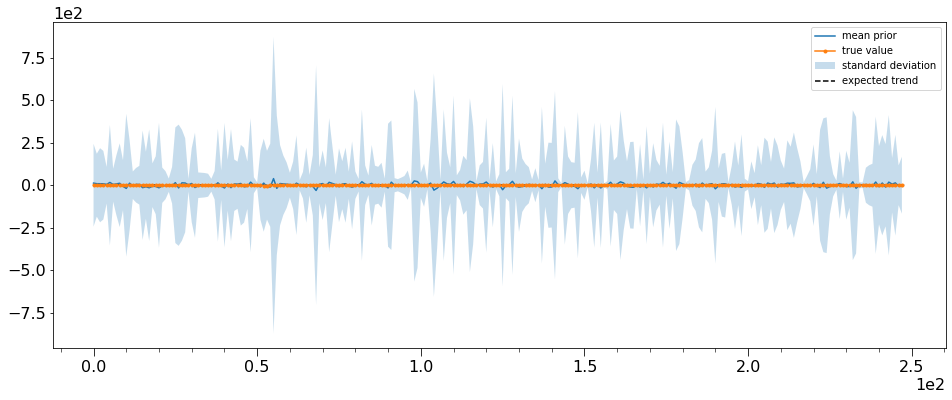

In [18]:
y = pm.sample_prior_predictive(model=mdl1, vars=['trend_lik'])['trend_lik']
pl.figure(figsize=(16, 6))
pl.plot(y.mean(0), label='mean prior')
pl.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, 
                label='standard deviation')
pl.plot(y_s, marker='.', label='true value', )
pl.hlines(0, 0,  t.size, linestyles='--', label='expected trend')
pl.legend();

In [19]:
t

array([0.        , 0.00404858, 0.00809717, 0.01214575, 0.01619433,
       0.02024291, 0.0242915 , 0.02834008, 0.03238866, 0.03643725,
       0.04048583, 0.04453441, 0.048583  , 0.05263158, 0.05668016,
       0.06072874, 0.06477733, 0.06882591, 0.07287449, 0.07692308,
       0.08097166, 0.08502024, 0.08906883, 0.09311741, 0.09716599,
       0.10121457, 0.10526316, 0.10931174, 0.11336032, 0.11740891,
       0.12145749, 0.12550607, 0.12955466, 0.13360324, 0.13765182,
       0.1417004 , 0.14574899, 0.14979757, 0.15384615, 0.15789474,
       0.16194332, 0.1659919 , 0.17004049, 0.17408907, 0.17813765,
       0.18218623, 0.18623482, 0.1902834 , 0.19433198, 0.19838057,
       0.20242915, 0.20647773, 0.21052632, 0.2145749 , 0.21862348,
       0.22267206, 0.22672065, 0.23076923, 0.23481781, 0.2388664 ,
       0.24291498, 0.24696356, 0.25101215, 0.25506073, 0.25910931,
       0.26315789, 0.26720648, 0.27125506, 0.27530364, 0.27935223,
       0.28340081, 0.28744939, 0.29149798, 0.29554656, 0.29959